In [1]:
import torch
from torch import nn
from torch import optim
from torchvision import transforms
import torchvision
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt

def imshow(img, ax=None):
    npimg = img.detach().numpy()
    npimg = npimg / 2 + 0.5  # обратное афинное преобразование
    if ax is None:
        if npimg.shape[0] == 1:  # 1 channel
            plt.imshow(np.squeeze(npimg))
        else:  # 3 channels
            plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()
    else:
        if npimg.shape[0] == 1:  # 1 channel
            ax.imshow(np.squeeze(npimg))
        else:  # 3 channels
            ax.imshow(np.transpose(npimg, (1, 2, 0)))

In [4]:
from generators import SimpleImageGenerator

In [5]:
noise_dimension = 10
def uniform_noise_generator(n: int) -> torch.Tensor:
    return torch.rand(size=(n, noise_dimension))

In [13]:
generator = SimpleImageGenerator(noise_dim=noise_dimension, output_shape=(1, 32, 32))

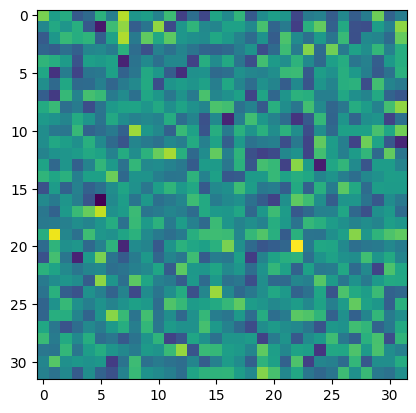

In [14]:
imshow(generator(uniform_noise_generator(1))[0])

In [15]:
from discriminators import SimpleImageDiscriminator

In [16]:
discr = SimpleImageDiscriminator()

In [18]:
discr(generator(uniform_noise_generator(1)))

tensor([[-0.0445]], grad_fn=<AddmmBackward0>)

## Обучение GAN на MNIST

In [19]:
from device import get_local_device

In [20]:
from gan import GAN

In [21]:
def gen_several_images(gan_model: GAN, n: int = 5):
    """
    Выводит n изображений, сгенерированных gan_model в строке
    """
    fig, axs = plt.subplots(nrows=1, ncols=n, figsize=(13, 13))
    gan_model.to(get_local_device())
    with torch.no_grad():
        noise_batch = gan_model.gen_noise(n).to(get_local_device())
        gen_batch = gan_model.generator(noise_batch)
    for tensor, ax in zip(gen_batch, axs):
        imshow(tensor.cpu(), ax=ax)
        
    plt.show()

In [22]:
from data import get_mnist_dataset, default_image_transform

In [23]:
mnist_dataset = get_mnist_dataset()

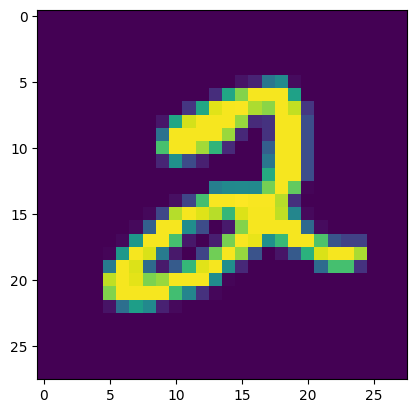

In [24]:
imshow(mnist_dataset[5][0])

In [13]:
from main import form_gan_trainer

In [29]:
gan_trainer = form_gan_trainer(model_name='mnist_test', n_epochs=4000)

epochs done: 200


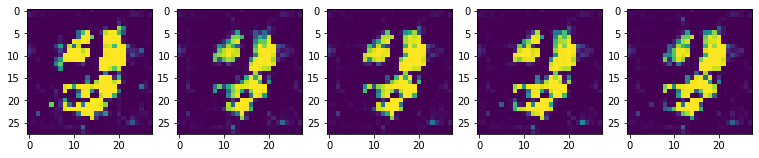

epochs done: 400


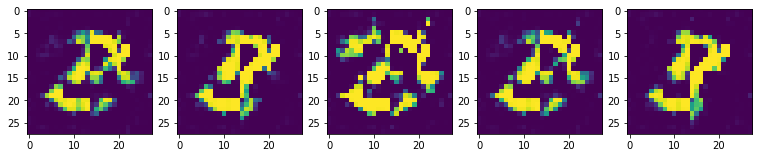

epochs done: 600


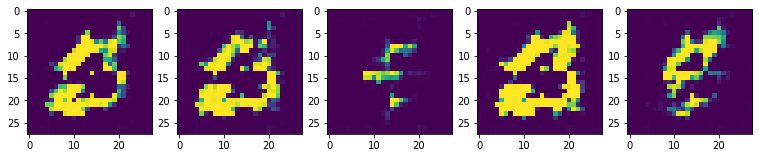

epochs done: 800


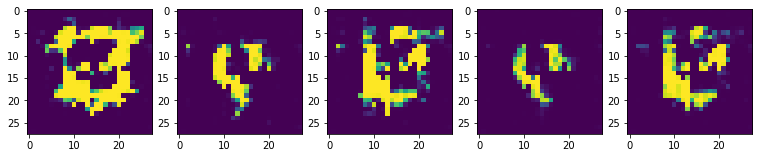

epochs done: 1000


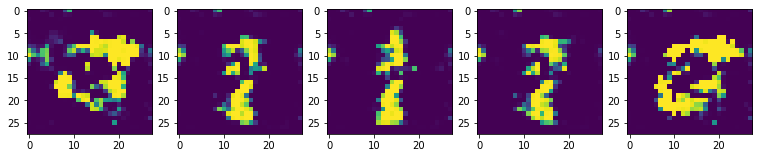

epochs done: 1200


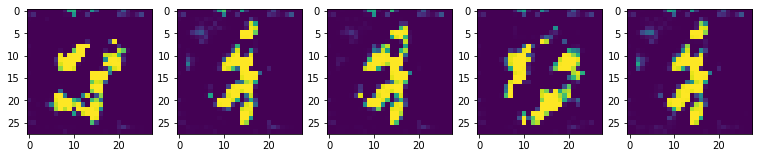

epochs done: 1400


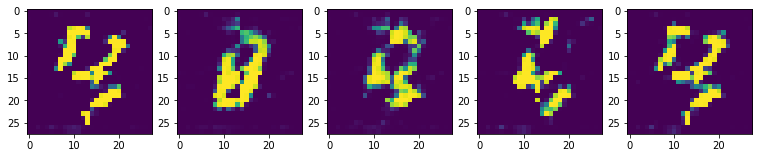

epochs done: 1600


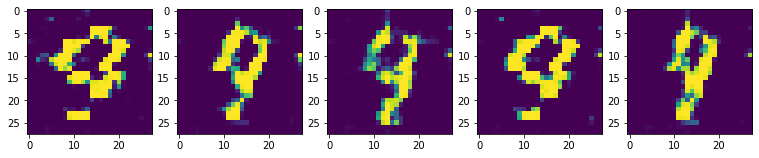

epochs done: 1800


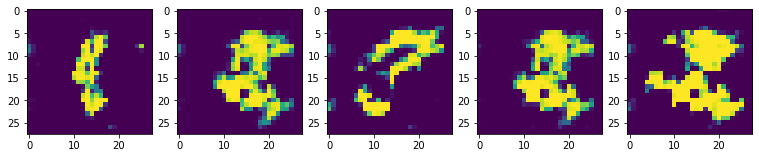

epochs done: 2000


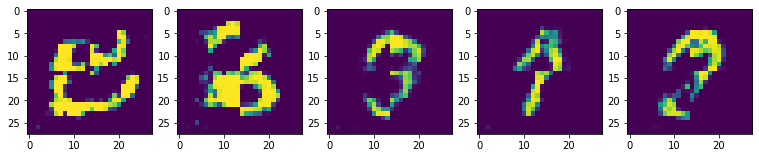

epochs done: 2200


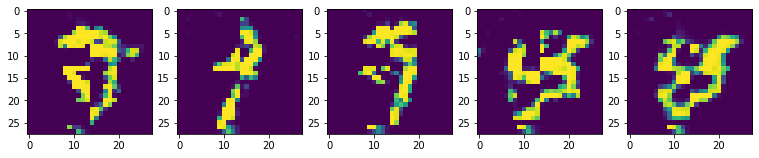

epochs done: 2400


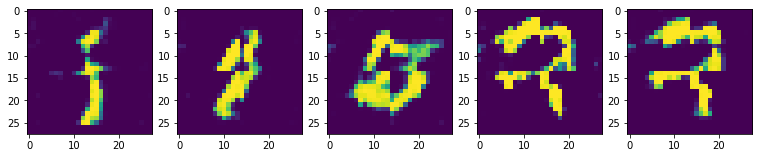

epochs done: 2600


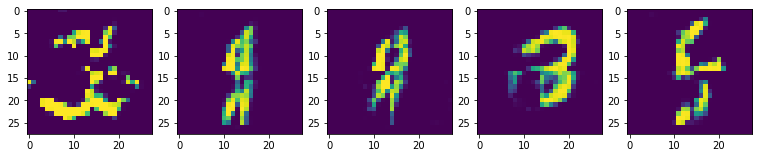

epochs done: 2800


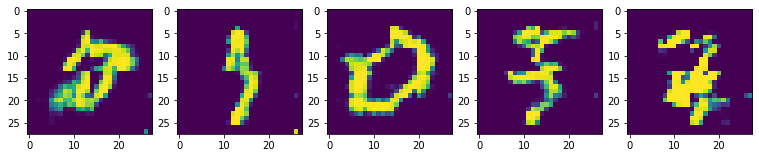

epochs done: 3000


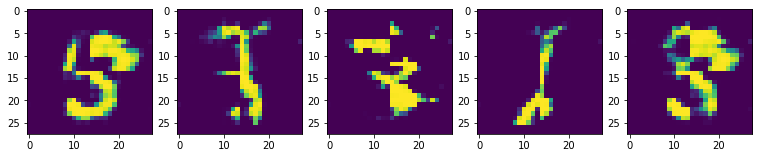

epochs done: 3200


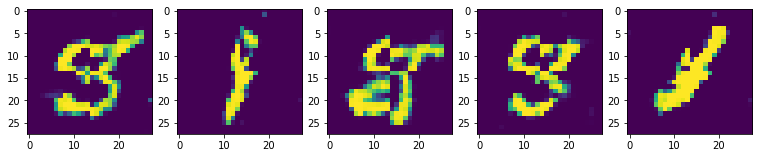

epochs done: 3400


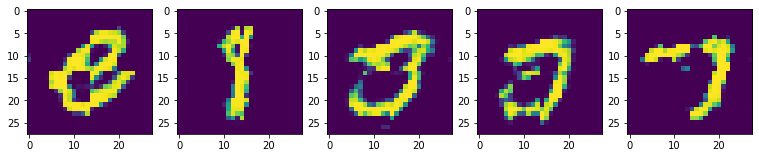

epochs done: 3600


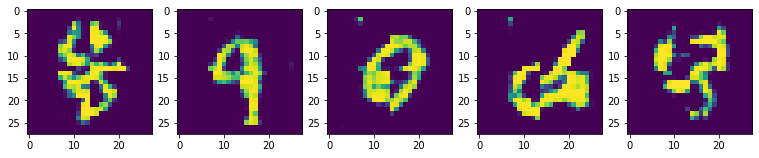

epochs done: 3800


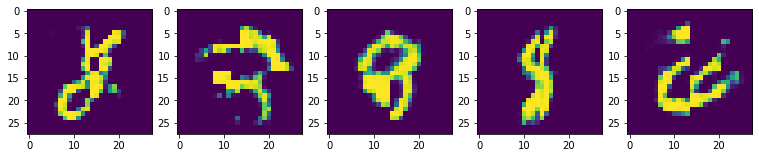

epochs done: 4000


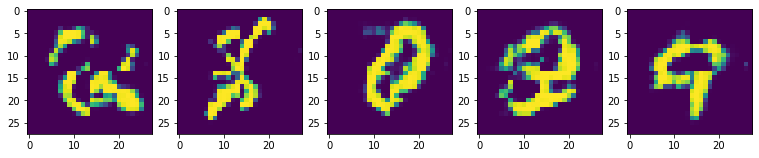

In [30]:
for epoch, gan in gan_trainer:
    if epoch % 200 == 0:
        print(f'epochs done: {epoch}')
        gen_several_images(gan, 5)